[*********************100%***********************]  1 of 1 completed


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
ARIMA RMSE: 118.98
SARIMA RMSE: 93.35
LSTM RMSE: 10.65


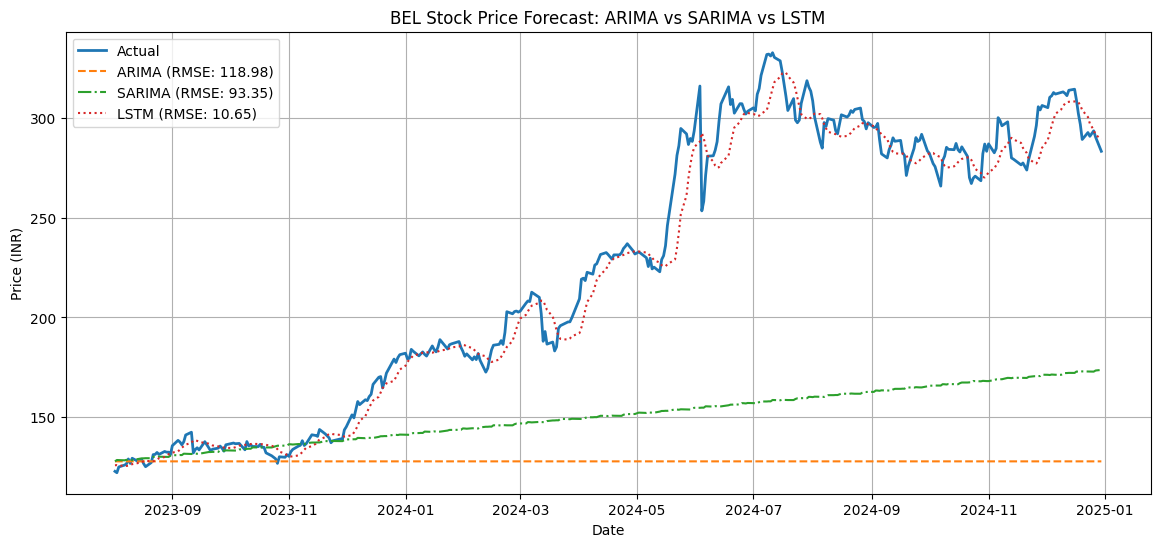

In [ ]:
# --- 1. Install and import necessary libraries ---
!pip install yfinance tensorflow --quiet

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from google.colab import files
import warnings
warnings.filterwarnings("ignore")

# --- 2. Download and save BEL data ---
symbol = "BEL.NS"
df = yf.download(symbol, start="2018-01-01", end="2024-12-31")
df.to_csv("bharat_electronics.csv")
files.download("bharat_electronics.csv")
data = df['Close']

# --- 3. Train-test split ---
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# --- 4. ARIMA Forecasting (manual order selection) ---
def arima_forecast(train, test, order=(1,1,1)):
    model = ARIMA(train, order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test))
    return forecast

# --- 5. SARIMA Forecasting (manual seasonal order) ---
def sarima_forecast(train, test, order=(1,1,1), seasonal_order=(0,1,1,12)):
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order, enforce_stationarity=False)
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(steps=len(test))
    return forecast

# --- 6. LSTM Forecasting ---
def lstm_forecast(series, train_size, look_back=60, epochs=20):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(series.values.reshape(-1,1))

    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i])
        y.append(scaled_data[i])
    X, y = np.array(X), np.array(y)

    X_train, X_test = X[:train_size-look_back], X[train_size-look_back:]
    y_train, y_test = y[:train_size-look_back], y[train_size-look_back:]

    model = Sequential()
    model.add(LSTM(64, input_shape=(look_back, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=0)

    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions).flatten()
    y_test_inv = scaler.inverse_transform(y_test)
    return predictions, y_test_inv.flatten()

# --- 7. Run forecasts ---
arima_preds = arima_forecast(train, test)
sarima_preds = sarima_forecast(train, test)
lstm_preds, lstm_actuals = lstm_forecast(data, train_size)

# --- 8. Evaluation ---
arima_rmse = np.sqrt(mean_squared_error(test, arima_preds))
sarima_rmse = np.sqrt(mean_squared_error(test, sarima_preds))
lstm_rmse = np.sqrt(mean_squared_error(lstm_actuals, lstm_preds))

print(f"ARIMA RMSE: {arima_rmse:.2f}")
print(f"SARIMA RMSE: {sarima_rmse:.2f}")
print(f"LSTM RMSE: {lstm_rmse:.2f}")

# --- 9. Plot results ---
plt.figure(figsize=(14,6))
plt.plot(test.index, test, label='Actual', linewidth=2)
plt.plot(test.index, arima_preds, label=f'ARIMA (RMSE: {arima_rmse:.2f})', linestyle='--')
plt.plot(test.index, sarima_preds, label=f'SARIMA (RMSE: {sarima_rmse:.2f})', linestyle='-.')
plt.plot(test.index[-len(lstm_preds):], lstm_preds, label=f'LSTM (RMSE: {lstm_rmse:.2f})', linestyle=':')
plt.title('BEL Stock Price Forecast: ARIMA vs SARIMA vs LSTM')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.grid(True)
plt.show()